# Mutual Unbiased Bases as a Countermeasure to Barren Plateaus in Variational Quantum Algorithms

### Imports and Globals

In [85]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from operator import truediv
from cmath import pi
from random import randint
import os
import time
%matplotlib inline

# MUB circuit file paths
MUB_CIRC_2_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '2_302')
MUB_CIRC_3_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '3_306')

# Result folder names paths
VQC_FOLDER = 'VQC results'
STATS_FILENAME = 'stats.txt'

RANDOM_THETAS_FOLDER = 'control group'
MUBS_FOLDER = 'mub states'
HALF_MUBS_FOLDER = 'half mubs'

OPTIMIZER_FOLDER = 'local cost optimizer experiments'
EXP_1_FOLDER = 'reproduction results'
EXP_2_FOLDER = 'local cost 3 qubits'
EXP_3_FOLDER = 'local cost 7 qubits'

LOAD_STATS_FROM_FILES = False

# Hyper-parameter value options
EPS_TOL = 1e-12
LO_TOL = 1e-5
MID_TOL = 1e-2
HI_TOL = 0.2
TINY_SUCCESS_BOUND = 0.01
LO_SUCCESS_BOUND = 0.1
HI_SUCCESS_BOUND = 0.4

# Maximal Iteration upper bound (set to not be reached)
MAX_ITER = 1e8

# Circuit Execution Parameters
SHOTS = 8192
qasm_backend = Aer.get_backend('qasm_simulator')
qasm_qi = QuantumInstance(qasm_backend, shots=SHOTS)

## Definitions and Functions

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The "Arrasmith" ansatz circuit is taken from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

The attempted task is "trivial" Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.
I took this specific problem from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

Note, however, an important observation:
In order to actually use the "value" of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

In [86]:
def gen_vqc_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc

### Default Experiment Parameters and Hyper-parameters

In [ ]:
class Parameters:
    def __init__(self, n_qubits: int, n_layers: int, optimizer: str, tol: float, success_bound: float, k: int, q: float):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.optimizer = optimizer
        self.tol = tol
        self.success_bound = success_bound
        self.k = k
        self.q = q

def get_std_params_3_qubits():
    return Parameters(n_qubits=3, n_layers=12, optimizer='COBYLA', tol=LO_TOL, success_bound=LO_SUCCESS_BOUND, k=25, q=0)

def get_std_params_7_qubits():
    return Parameters(n_qubits=7, n_layers=7, optimizer='COBYLA', tol=LO_TOL, success_bound=LO_SUCCESS_BOUND, k=25, q=0)

In [87]:
optimizer = ''
success_bound = tol = K = N_LAYERS = N_QUBITS= 0
def std_exp_3_qubits():
    global optimizer
    global success_bound
    global tol
    global K
    global N_LAYERS
    global N_QUBITS
    optimizer = 'COBYLA'
    success_bound = LO_SUCCESS_BOUND
    tol = LO_TOL
    K = 25
    N_LAYERS = 12
    N_QUBITS = 3
    
def std_exp_7_qubits():
    global optimizer
    global success_bound
    global tol
    global K
    global N_LAYERS
    global N_QUBITS
    optimizer = 'COBYLA'
    success_bound = LO_SUCCESS_BOUND
    tol = LO_TOL
    K = 25
    N_LAYERS = 7
    N_QUBITS = 7

std_exp_3_qubits()

### Experiment Functions - Generic VQC experiment

In [88]:
def low_constraint(x: List[float]):
    return min(x)

def hi_constraint(x: List[float]):
    return 2*pi-max(x)

def get_constraints() -> List[dict]:
    return [{'type': 'ineq', 'fun': low_constraint}, {'type': 'ineq', 'fun': hi_constraint}]

def rand_angle():
    return (np.random.random()) * 2 * pi - pi

# Calculate the percentage of results where 0 was reached in the jth qubit.
def get_p0j(counts: dict, j: int, n_qubits: int, shots: int = SHOTS) -> float:
    assert j >= 0 and j < n_qubits
    count0j = sum([v for k,v in counts.items() if k[j] == '0'])
    assert count0j >= 0 and count0j <= shots
    return count0j / shots

# Returns the number of function evaluations it took for the method to converge.
# If during the optimization, the cost function goes below a specified bound, the optimization halts.
# If the optimization halted because of the bound, the OptimizeResult is replaced with None.
def run_vqc_exp(qc: QuantumCircuit,
                theta0: List[float],
                params: Parameters = get_std_params_3_qubits()) -> Tuple[List[float], bool]:
    
    cost_points = []
    
    # Exception used for breaking on hitting success bound
    class BoundHitException(Exception):
        pass
    
    
    def evaluate_cost(theta: List[float]) -> float:
        if float('inf') in theta or float('-inf') in theta:
            raise ZeroDivisionError()
        concrete_qc = qc.bind_parameters(theta)
        results = QI.execute(concrete_qc)
        counts = dict(results.get_counts())
        # Calculating the cost
        # Note that the Arrasmith paper uses ONLY the local cost.
        # Also, note that while the initial global cost is close to 1, the initial local cost should be around 0.5.
        # The intuition is that the probability to be in |0> specifically vanishes exponentially,
        # While the amount of "lit" qubits in a random answer should be around half.
        global_cost = 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)
        local_cost = 1 - sum([get_p0j(counts, j, params.n_qubits) for j in range(params.n_qubits)]) / params.n_qubits
        cost = params.q * global_cost + (1-params.q) * local_cost
        cost_points.append(cost)
        if (cost) <= params.success_bound:
            print('Success bound reached. WOOP')
            raise BoundHitException()
        return cost

    try:
        # Based on constraint functions
        if params.optimizer == 'COBYLA':
            res = minimize(evaluate_cost,
                theta0,
                method='COBYLA',
                options={'maxiter': MAX_ITER},
                tol=params.tol,
                constraints=get_constraints())
        #based on concrete bounds
        elif params.optimizer in ['Nelder-Mead', 'SLSQP', 'Powell']:
            res = minimize(evaluate_cost,
                theta0,
                method=params.optimizer,
                options={'maxiter': MAX_ITER},
                tol=params.tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        else:
            assert 0==1
        
    except BoundHitException:
        return cost_points, True
    except ZeroDivisionError:
        return cost_points, cost_grad
    except KeyboardInterrupt:
        print('Optimization stopped by keyboard interrupt. WOLOLO')
        return cost_points, False

    return cost_points, res

### Experiment Functions - prepending circuits

In [89]:
# This function gets a number i from 0 to (2^n)-1
# and returns a circuit that generates the state |i> when acting on |0>.
def get_comp_state_circ(state_idx: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    bin_str = bin(state_idx)[2:].zfill(n_qubits)
    for i, ch in enumerate(bin_str):
        if ch == '1':
            qc.x(i)
    return qc

def get_comp_circuits(n_qubits: int):
    return [get_comp_state_circ(i, n_qubits) for i in range(2 ** n_qubits)]


def run_vqc_exp_with_state_prepend(ansatz_qc: QuantumCircuit, state_qc: QuantumCircuit,
                                   theta0: List[float],
                                   params: Parameters = get_std_params_3_qubits()) -> Tuple[list, bool]:
    state_qc = state_qc.copy()
    state_qc.add_register(ClassicalRegister(params.n_qubits))
    full_qc = state_qc.compose(ansatz_qc, qubits=range(params.n_qubits), inplace=False)
    assert full_qc != None
    return run_vqc_exp(qc=full_qc, theta0=theta0, params=params)


def run_vqc_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit,
                                 theta0: List[float],
                                 params: Parameters = get_std_params_3_qubits()) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(params.n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(params.n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** params.n_qubits)):
        state_qc = get_comp_state_circ(i, params.n_qubits)
        res_dict[i] = run_vqc_exp_with_state_prepend(mub_ansatz_qc, state_qc, theta0, params=params)
    return res_dict


In [90]:
std_exp_3_qubits()

### Control Group: $k$ Random Initial Parameter Vectors

#### Result Data Structure

The results are a list of tuples.
The first element is the theta vector used for that run.
The second element is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [91]:
def run_k_random_theta_vqc_exp_set(params: Parameters = get_std_params_3_qubits()):
    print('=====Experimenting with SMALL SETS of radnom initial parameters=====')
    start_time = time.time()
    first_time = start_time
    finish_time = start_time
    interrupted = False
    
    results = []
    ansatz = gen_vqc_ansatz_arrasmith(n_qubits=params.n_qubits, n_layers=params.n_layers)

    for i in range(params.k):
        theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
        print(f'experimenting with random parameter set #{i}')
        exp_data = run_vqc_exp(ansatz, theta0, params)
        print(f'parameter set #{i} done')
        
        if exp_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            exp_data = (exp_data[0], [])
        elif exp_data[1] == True:
            state_data = (exp_data[0], [])

        finish_time = time.time()
        print(f'Finished experiment in {finish_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = finish_time

        results.append((theta0, exp_data))

        if interrupted:
            return results, False
        
    print(f'total took {finish_time - first_time} seconds')
    
    return results, True

### Loading the QASM MUB circuits into Qiskit

In [92]:
CIRC_FROM_FILES = True
if CIRC_FROM_FILES:
    paths_2 = os.listdir(MUB_CIRC_2_PATH)
    paths_3 = os.listdir(MUB_CIRC_3_PATH)
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_2_PATH,path)) for path in paths_2 if '.txt' in path]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths_3 if '.txt' in path]
else:
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_2_302.values()]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_3_306.values()]

### Utilization Method: try k random MUB states

#### Results Data Structure
The results of the experiment are a dictionary.
The key is a pair: the first element is the MUB index, and the second is the state index.
The value is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [93]:
def generate_k_mub_choices(k: int, n_qubits: int) -> List[Tuple[int, int]]:
    n_mubs = 2 ** n_qubits + 1
    n_states = 2 ** n_qubits
    assert k <= n_mubs * n_states
    res = []
    while k > 0:
        while True:
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (mub, state) not in res:
                res.append((mub, state))
                k -= 1
                break
    return res

In [94]:
def run_k_mub_state_vqc_exp_set(params: Parameters = get_std_params_3_qubits()):
    print('=====Experimenting with SMALL SETS of prepended MUB states=====')
    start_time = time.time()
    first_time = start_time
    finish_time = start_time
    interrupted = False
    results = {}
    
    ansatz = gen_vqc_ansatz_arrasmith(params.n_qubits, params.n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = generate_k_mub_choices(k=params.k, n_qubits=params.n_qubits)

    for mub, state in state_choices:
        print(f'experimenting with MUB {mub}, state {state}')
        mub_qc = mub_circuits_3_qubits[mub].copy()
        state_qc = get_comp_state_circ(state_idx=state, n_qubits=params.n_qubits).copy()
        full_state_qc = state_qc.compose(mub_qc, inplace=False)
        assert full_state_qc != None
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, theta0, params)
        print(f'({mub},{state}) done')

        if state_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            state_data = (state_data[0], [])
        elif state_data[1] == True:
            state_data = (state_data[0], [])

        finish_time = time.time()
        print(f'Finished experiment in {finish_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = finish_time

        results[(mub, state)] = state_data

        if interrupted:
            return results, False

    print(f'total took {finish_time - first_time} seconds')
    return results, True

### Utilization Method: Try k half-MUBs

When working with $n$ qubits, there is an exponential number of MUBs, and each MUB has an exponential number of states.

The generation of all of these MUB transformations takes exponential time by itself.

To mitigate that, Tal proposed the following idea:
Pick a pair of qubits in an $n$-qubit register. generate a 2-qubit MUB state between them, and put the rest on 0.

This method has a polynomial amount of states, and spans an interesting part of the space.

#### Results Data Structure
The results of the experiment are a dict from the n of layers and qubits to the results for that n.

Each layer's results are also a dictionary.
The key is a 4-tuple: the two first places are the pairs of qubits on which the MUB state was generated, the third is the MUB index, and the fourth is the state index.
The value is a tuple of the convergence graph, and (optionally) the result data structure generated by SciPy.

In [95]:
def gen_half_mub_circ_2_qubits(n_qubits: int, qubit_1: int, qubit_2: int, mub_no: int, state_no: int, mub_circuits: List[QuantumCircuit]) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    comp_state_qc = get_comp_state_circ(state_no, n_qubits=2)
    qc.compose(comp_state_qc, qubits=[qubit_1, qubit_2], inplace=True)
    qc.compose(mub_circuits[mub_no], qubits=[qubit_1, qubit_2], inplace=True)
    return qc

def gen_half_mub_circ_3_qubits(n_qubits: int, qubit_1: int, qubit_2: int, qubit_3: int,
                               mub_no: int, state_no: int, mub_circuits: List[QuantumCircuit]) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    comp_state_qc = get_comp_state_circ(state_no, n_qubits=3)
    qc.compose(comp_state_qc, qubits=[qubit_1, qubit_2, qubit_3], inplace=True)
    qc.compose(mub_circuits[mub_no], qubits=[qubit_1, qubit_2, qubit_3], inplace=True)
    return qc

def gen_k_half_mub_choices_2_qubits(n_qubits: int, k: int) -> List[Tuple[int, int, int, int]]:
    n_mubs = 2 ** 2 + 1
    n_states = 2 ** 2
    # m mubs * (n choose 2) pairs of qubits
    assert k <= n_mubs * n_qubits * (n_qubits-1) // 2
    res = []
    while k > 0:
        while True:
            qubit_1 = randint(0, n_qubits-2)
            qubit_2 = randint(qubit_1+1, n_qubits-1)
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (qubit_1, qubit_2, mub, state) not in res:
                res.append((qubit_1, qubit_2, mub, state))
                k -= 1
                break
    return res

def gen_k_half_mub_choices_3_qubits(n_qubits: int, k: int) -> List[Tuple[int, int, int, int, int]]:
    n_mubs = 2 ** 3 + 1
    n_states = 2 ** 3
    # m mubs * (n choose 3) pairs of qubits
    assert k <= n_mubs * n_qubits * (n_qubits-1) * (n_qubits-2) // 6
    res = []
    while k > 0:
        while True:
            qubit_1 = randint(0, n_qubits-3)
            qubit_2 = randint(qubit_1+1, n_qubits-2)
            qubit_3 = randint(qubit_2+1, n_qubits-1)
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (qubit_1, qubit_2, qubit_3, mub, state) not in res:
                res.append((qubit_1, qubit_2, qubit_3, mub, state))
                k -= 1
                break
    return res

In [96]:
def run_k_half_mub_state_2_qubit_vqc_exp_set(params: Parameters = get_std_params_3_qubits()):
    print('=====Experimenting with SMALL SETS of prepended half-MUB states=====')
    start_time = time.time()
    first_time = start_time
    finish_time = start_time
    interrupted = False
    results = {}
    
    ansatz = gen_vqc_ansatz_arrasmith(params.n_qubits, params.n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = gen_k_half_mub_choices_2_qubits(n_qubits=params.n_qubits, k=params.k)

    for choice in state_choices:
        print(f'experimenting with pair {(choice[0], choice[1])}, MUB {choice[2]}, state {choice[3]}')
        full_state_qc = gen_half_mub_circ_2_qubits(params.n_layers, *choice, mub_circuits_2_qubits)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, theta0, params=params)
        print(f'{choice} done')
        
        finish_time = time.time()
        print(f'Finished experiment in {finish_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = finish_time

        results[choice] = state_data

        if interrupted:
            return results, False
        

    print(f'total took {finish_time - first_time} seconds')
    return results, True

def run_k_half_mub_state_3_qubit_vqc_exp_set(params: Parameters = get_std_params_3_qubits()):
    print('=====Experimenting with SMALL SETS of prepended half-MUB states=====')
    start_time = time.time()
    first_time = start_time
    finish_time = start_time
    interrupted = False
    results = {}
    
    ansatz = gen_vqc_ansatz_arrasmith(params.n_qubits, params.n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = gen_k_half_mub_choices_3_qubits(n_qubits=params.n_qubits, k=params.k)

    for choice in state_choices:
        print(f'experimenting with triple {(choice[0], choice[1], choice[2])}, MUB {choice[3]}, state {choice[4]}')
        full_state_qc = gen_half_mub_circ_3_qubits(params.n_layers, *choice, mub_circuits_3_qubits)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, theta0, params=params)
        print(f'{choice} done')
        
        finish_time = time.time()
        print(f'Finished experiment in {finish_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = finish_time

        results[choice] = state_data

        if interrupted:
            return results, False
        

    print(f'total took {finish_time - first_time} seconds')
    return results, True

### Analysis Functions - General

In [103]:
def avg(col):
    col = list(filter(lambda x: x is not None, col)) # Remove 'None' values
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])
    
def first_idx(pred, lst):
    all_res = [x for x in range(len(lst)) if pred(lst[x])]
    return all_res[0] if all_res != [] else None


def nfev(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return len(evals)
    elif type(record) == VQEResult:
        return record.cost_function_evals
    else:
        assert type(record) == OptimizeResult
        return record.nfev
    
    
def fin_val(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> float:
    evals, record = data
    if evals != []:
        return evals[-1]
    elif type(record) == VQEResult:
        return record.eigenvalue
    else:
        return record.fun

def plot_and_save_convergence_graph(evals: List[float], target_vals: List[float], title: str, filename: str):
    plt.axis([0, len(evals), 0, 1])
    plt.plot(evals)
    plt.title(title)
    
    if target_vals != []:
        plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='red')
    for fake_target in target_vals[1:]:
        plt.plot([0, len(evals)-1], [fake_target, fake_target], color='purple')
        
    plt.savefig(filename)
    plt.show()

### Analysis Functions - Utilization Methods

In [98]:
def gen_statistics_random_thetas(random_thetas_results: List[Tuple[List[float],Tuple[List[float], VQEResult]]],
                                 params: Parameters = get_std_params_3_qubits(),
                                 target_vals: List[float] = [0],
                                 stats_folder: str = '',
                                 stats_filename: str = '',
                                 ) -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
    if not os.path.isdir(stats_folder):
        os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')
        
    assert target_vals != []
    
    stats = {}
    min_nfev = min([nfev(exp_data) for _, exp_data in random_thetas_results])
    stats['min_nfev'] = min_nfev
    stats['avg_nfev'] = avg([nfev(exp_data) for _, exp_data in random_thetas_results])
    correct_thetas = [fin_val(exp_data) for _, exp_data in random_thetas_results if fin_val(exp_data)-params.success_bound < 1e-2]
    stats['correct_thetas_count'] = len(correct_thetas)
    stats['correct_addition_percent'] = len(correct_thetas) / len(random_thetas_results)
    stats['correct_avg_val'] = avg(correct_thetas)

    stats['evals'] = {k: v[1][0] for k,v in enumerate(random_thetas_results)}
    stats['nfevs'] = {k: len(v[1][0]) for k,v in enumerate(random_thetas_results)}
    stats['fin_vals'] = {k: fin_val(v[1]) for k,v in enumerate(random_thetas_results)}
    
    for target_val in target_vals:
        stats[f'hit_{target_val}'] = {k: first_idx(lambda x: x <= target_val, v[1][0]) for k,v in enumerate(random_thetas_results)}
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(stats, f)
        
    for idx, evals in stats['evals'].items():
        plot_and_save_convergence_graph(evals=evals,
                        target_vals=target_vals,
                        title=f'Convergence graph with {params.n_layers} layers, theta #{idx}',
                        filename=os.path.join(stats_folder, f'{params.n_layers},{idx}.png'))
    
    return stats



# Analyze the performance of using MUB states as initial states for an ansatz
def gen_statistics_mubs(prepend_results_dict: Dict[Tuple[int, int], Tuple[List[float], VQEResult]],
                        params: Parameters = get_std_params_3_qubits(),
                        target_vals: List[float] = [0],
                        stats_folder: str = '',
                        stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
        if not os.path.isdir(stats_folder):
            os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')

    stats = {}
    min_nfev = min([nfev(state_data) for state_data in prepend_results_dict.values()])
    stats['min_nfev'] = min_nfev
    stats['avg_nfev'] = avg([nfev(state_data) for state_data in prepend_results_dict.values()])


    assert target_vals != []
    # Experiments that terminated closer to the intended result
    correct_states = {state_idx: fin_val(state_data) for state_idx, state_data in prepend_results_dict.items() if fin_val(state_data)-params.success_bound < 1e-2}        
    stats['correct_states'] = correct_states
    stats['correct_states_count'] = len(correct_states)
    stats['correct_addition_percent'] = len(correct_states) / len(prepend_results_dict)
    stats['correct_avg_val'] = avg(correct_states.values())

    stats['evals'] = {k: v[0] for k,v in prepend_results_dict.items()}
    stats['nfevs'] = {k: len(v[0]) for k,v in prepend_results_dict.items()}
    stats['fin_vals'] = {k: fin_val(v) for k,v in prepend_results_dict.items()}
    
    for target_val in target_vals:
        stats[f'hit_{target_val}'] = {k: first_idx(lambda x: x <= target_val, v[0]) for k,v in prepend_results_dict.items()}
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(stats, f)
        
    for idx, data in prepend_results_dict.items():
        plot_and_save_convergence_graph(evals=data[0],
                            target_vals=target_vals,
                            title=f'Convergence graph with {params.n_layers} layers, state {idx}',
                            filename=os.path.join(stats_folder, f'{params.n_layers},{idx[0]},{idx[1]}.png'))
    return stats


def gen_statistics_half_mubs_2_qubits(half_mubs_results_dict: Dict[Tuple[int, int, int, int], Tuple[List[float], VQEResult]],
                                        params: Parameters = get_std_params_3_qubits(),
                                        target_vals: List[float] = [0],
                                        stats_folder: str = '',
                                        stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
        if not os.path.isdir(stats_folder):
            os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')

    stats = {}
    min_nfev = min([nfev(state_data) for state_data in half_mubs_results_dict.values()])
    stats['min_nfev'] = min_nfev
    stats['avg_nfev'] = avg([nfev(state_data) for state_data in half_mubs_results_dict.values()])

    assert target_vals != []
    # Experiments that terminated closer to the intended result
    correct_states = {choice: fin_val(state_data) for choice, state_data in half_mubs_results_dict.items() if fin_val(state_data)-params.success_bound < 1e-2}        
    stats['correct_states'] = correct_states
    stats['correct_states_count'] = len(correct_states)
    stats['correct_addition_percent'] = len(correct_states) / len(half_mubs_results_dict)
    stats['correct_avg_val'] = avg(correct_states.values())

    stats['evals'] = {k: v[0] for k,v in half_mubs_results_dict.items()}
    stats['nfevs'] = {k: len(v[0]) for k,v in half_mubs_results_dict.items()}
    stats['fin_vals'] = {k: fin_val(v) for k,v in half_mubs_results_dict.items()}
    
    for target_val in target_vals:
        stats[f'hit_{target_val}'] = {k: first_idx(lambda x: x <= target_val, v[0]) for k,v in half_mubs_results_dict.items()}
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(stats, f)
        
    for idx, data in half_mubs_results_dict.items():
        plot_and_save_convergence_graph(evals=data[0],
                            target_vals=target_vals,
                            title=f'Convergence graph with {params.n_layers} layers, pair ({idx[0]},{idx[1]}), MUB state({idx[2]},{idx[3]})',
                            filename=os.path.join(stats_folder, f'{params.n_layers}_{idx[0]},{idx[1]}_{idx[2]},{idx[3]}.png'))
    return stats




def gen_statistics_half_mubs_3_qubits(half_mubs_results_dict: Dict[Tuple[int, int, int, int, int], Tuple[List[float], VQEResult]],
                                        params: Parameters = get_std_params_3_qubits(),
                                        target_vals: List[float] = [0],
                                        stats_folder: str = '',
                                        stats_filename: str = '') -> Dict[int, Dict[str, any]]:
    
    if stats_folder == '':
        stats_folder = input('enter path for results directory')
        if not os.path.isdir(stats_folder):
            os.mkdir(stats_folder)
    if stats_filename == '':
        stats_filename = input('enter filename for statistics file')

    stats = {}
    min_nfev = min([nfev(state_data) for state_data in half_mubs_results_dict.values()])
    stats['min_nfev'] = min_nfev
    stats['avg_nfev'] = avg([nfev(state_data) for state_data in half_mubs_results_dict.values()])

    assert target_vals != []
    # Experiments that terminated closer to the intended result
    correct_states = {choice: fin_val(state_data) for choice, state_data in half_mubs_results_dict.items() if fin_val(state_data)-params.success_bound < 1e-2}        
    stats['correct_states'] = correct_states
    stats['correct_states_count'] = len(correct_states)
    stats['correct_addition_percent'] = len(correct_states) / len(half_mubs_results_dict)
    stats['correct_avg_val'] = avg(correct_states.values())

    stats['evals'] = {k: v[0] for k,v in half_mubs_results_dict.items()}
    stats['nfevs'] = {k: len(v[0]) for k,v in half_mubs_results_dict.items()}
    stats['fin_vals'] = {k: fin_val(v) for k,v in half_mubs_results_dict.items()}
    
    for target_val in target_vals:
        stats[f'hit_{target_val}'] = {k: first_idx(lambda x: x <= target_val, v[0]) for k,v in half_mubs_results_dict.items()}
        
    with open(os.path.join(stats_folder, stats_filename), 'w') as f:
        pprint(stats, f)
        
    for idx, data in half_mubs_results_dict.items():
        plot_and_save_convergence_graph(evals=data[0],
                            target_vals=target_vals,
                            title=f'Convergence graph with {params.n_layers} layers, triple ({idx[0]},{idx[1]},{idx[2]}), MUB state({idx[2]},{idx[3]})',
                            filename=os.path.join(stats_folder, f'{params.n_layers}_{idx[0]},{idx[1]},{idx[2]}_{idx[3]},{idx[4]}.png'))
    return stats

## Experiments

### (Optionally) Load Data Fom Files

In [99]:
from ast import literal_eval

def load_stats(name: str) -> dict:
    with open(name, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

### Plotting Functions

In [100]:
def myplot(data: dict, title: str = '', label: str = '', logscale=False, xaxis='', yaxis=''):
    data = {k: v for k,v in data.items() if v != None}
    lists = sorted(data.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    if logscale:
        plt.yscale('log')
    plt.plot(x, y, label=label, marker='o')


def compare_same_qubits_experiments_from_evals(evals1, evals2, 
                                    color1='blue', color2='red',
                                    label1='experiment', label2='cotrol',
                                    filename='scatterplot'):
    make_joint_scatterplot([(evals1, label1, color1), (evals2, label2, color2)])
    plt.legend()
    plt.savefig(filename, dpi=800)
    plt.show()

def filter_failed_experiment_evals(evals, success_bound=0.4):
    return filter(lambda lst: lst[-1] <= success_bound, evals)

def compare_same_qubits_experiments_from_stats(nfev1, nfev2,
                                               finval1, finval2, 
                                               color1='blue', color2='red',
                                               label1='cotrol', label2='experiment',
                                               filename='scatterplot'):
    make_joint_scatterplot_from_stats([(nfev1, finval1, label1, color1), (nfev2, finval2, label2, color2)])
    plt.xlabel('nfevs')
    plt.ylabel('final value reached')
    plt.legend()
    plt.savefig(filename, dpi=800)
    plt.show()


    
def compare_different_qubit_experiments(exp_list, filename='nfev_plot'):
    for nfev_dict, label, color in exp_list:
        myplot(nfev_dict, c=color, label=label)
    
    plt.legend()
    plt.savefig(filename, dpi=800)
    plt.plot()

### Hyper-Parameter Experiments: Choosing TOL

#### COBYLA optimizer

In [ ]:
params = get_std_params_3_qubits()
cobyla_tol_results = []
tols = [HI_TOL, MID_TOL, LO_TOL, EPS_TOL]
for currtol in tols:
    params.tol = currtol
    results, graceful = run_k_random_theta_vqc_exp_set(params)
    cobyla_tol_results.append(results)
    if not graceful:
        break

#### Powell optimizer

In [ ]:
params = get_std_params_3_qubits()
params.optimizer = 'Powell'
powell_tol_results = []
tols = [HI_TOL, MID_TOL, LO_TOL, EPS_TOL]
for currtol in tols:
    params.tol = currtol
    results, graceful = run_k_random_theta_vqc_exp_set(params)
    powell_tol_results.append(results)
    if not graceful:
        break

#### Nelder-Mead optimizer

In [ ]:
params = get_std_params_3_qubits()
params.optimizer = 'Nelder-Mead'
nm_tol_results = []
tols = [HI_TOL, MID_TOL, LO_TOL, EPS_TOL]
for currtol in tols:
    params.tol = currtol
    results, graceful = run_k_random_theta_vqc_exp_set(params)
    nm_tol_results.append(results)
    if not graceful:
        break

#### Analysis: choosing TOL

In [ ]:
tols = [HI_TOL, MID_TOL, LO_TOL, EPS_TOL]

def gen_tol_stats(tol_results):
    for i, tolval in enumerate(tols):
        if i >= len(tol_results):
            break
        print(f'stats for tol={tolval}')
        all_nfevs = [len(exp[1][0]) for exp in tol_results[i]]
        all_costs = [exp[1][0][-1] for exp in tol_results[i]]
        print(f'avg nfev is {avg(all_nfevs)}')
        print(f'amount of experiments that succeeded is {len(list(filter(lambda x: x <= 0.1, all_costs)))}.')

In [ ]:
gen_tol_stats(cobyla_tol_results)
gen_tol_stats(powell_tol_results)
gen_tol_stats(nm_tol_results)

### Hyper-Parameter Experiments: Choosing the Optimizer

#### COBYLA optimizer

In [ ]:
params = get_std_params_7_qubits()
random_thetas_results_cobyla = {}
for n in range(4,8):
    params.n_qubits = params.n_layers = n
    random_thetas_results_cobyla[n], graceful = run_k_random_theta_vqc_exp_set(params)
    if not graceful:
        break

#### Powell optimizer

In [ ]:
params = get_std_params_7_qubits()
params.optimizer = 'Powell'
random_thetas_results_powell = {}
for n in range(4,8):
    params.n_qubits = params.n_layers = n
    random_thetas_results_powell[n], graceful = run_k_random_theta_vqc_exp_set(params)
    if not graceful:
        break

=====Experimenting with SMALL SETS of radnom initial parameters=====
experimenting with random parameter set #0
Success bound reached. WOOP
parameter set #0 done
Finished experiment in 2499.978082180023 seconds at Fri Oct  7 17:15:15 2022
experimenting with random parameter set #1
Success bound reached. WOOP
parameter set #1 done
Finished experiment in 5550.1920754909515 seconds at Fri Oct  7 18:47:46 2022
experimenting with random parameter set #2


In [77]:
random_thetas_results_powell = random_thetas_results

#### Analysis: Choosing an optimizer

In [105]:
def gen_optimizer_stats(results, params: Parameters):
    stats = {}
    for n in range(4,8):
        params.n_qubits = params.n_layers = n
        print(f'stats for n={n}')
        stats[n] = gen_statistics_random_thetas(results[n],
                                     target_vals = [HI_SUCCESS_BOUND, LO_SUCCESS_BOUND],
                                     stats_folder = os.path.join(VQC_FOLDER, OPTIMIZER_FOLDER, params.optimizer)
                                     stats_filename = f'{n}_layers_{STATS_FILENAME}')
        print(f'average nfev: {avg(list(stats[n]["nfevs"].values()))}')
        print(f'amount of experiments that reached {HI_SUCCESS_BOUND} is {len([finval for finval in stats[n]["fin_vals"].values() if finval <= HI_SUCCESS_BOUND])}/{len(stats[n]["fin_vals"])}.')
        print(f'amount of experiments that reached {LO_SUCCESS_BOUND} is {len([finval for finval in stats[n]["fin_vals"].values() if finval <= LO_SUCCESS_BOUND])}/{len(stats[n]["fin_vals"])}.')

    hi_nfev_dict = {n: v[f'hit_{HI_SUCCESS_BOUND}'] for n,v in stats.items()}
    lo_nfev_dict = {n: v[f'hit_{LO_SUCCESS_BOUND}'] for n,v in stats.items()}
    myplot(hi_nfev_dict, title=f'nfev per Number of qubits, {params.optimizer} optimizer, success bound {HI_SUCCESS_BOUND}', logscale=True)
    plt.show()
    myplot(lo_nfev_dict, title=f'nfev per Number of qubits, {params.optimizer} optimizer, success bound {LO_SUCCESS_BOUND}', logscale=True)
    plt.show()

    for n in range(4,8):
        print(f'stats for n={n}')
        print(f'average nfev: {avg(list(stats[n]["nfevs"].values()))}')
        print(f'amount of experiments that reached {HI_SUCCESS_BOUND} is {len([finval for finval in stats[n]["fin_vals"].values() if finval <= HI_SUCCESS_BOUND])}/{len(stats[n]["fin_vals"])}.')
        print(f'amount of experiments that reached {LO_SUCCESS_BOUND} is {len([finval for finval in stats[n]["fin_vals"].values() if finval <= LO_SUCCESS_BOUND])}/{len(stats[n]["fin_vals"])}.')

    return stats

AAAAAAAAAAAAAAAA


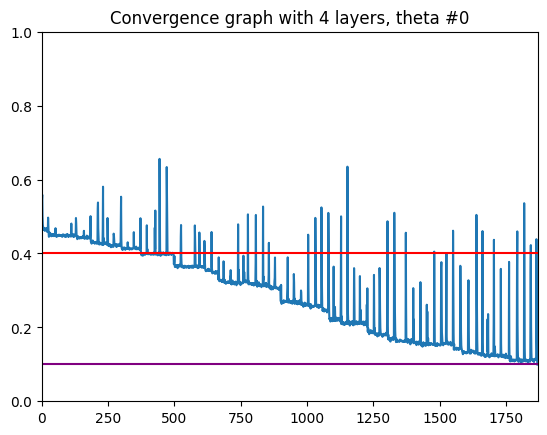

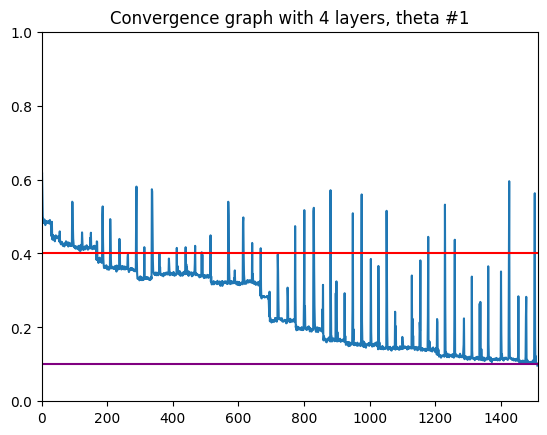

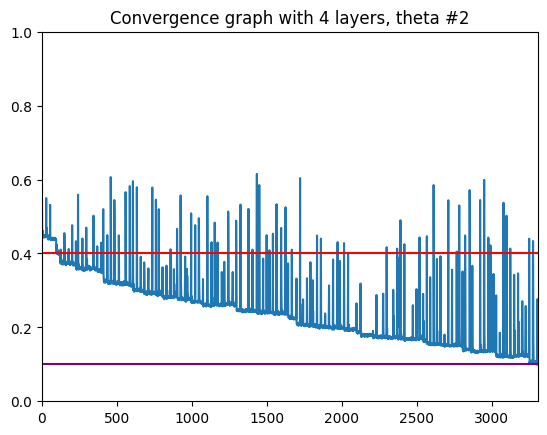

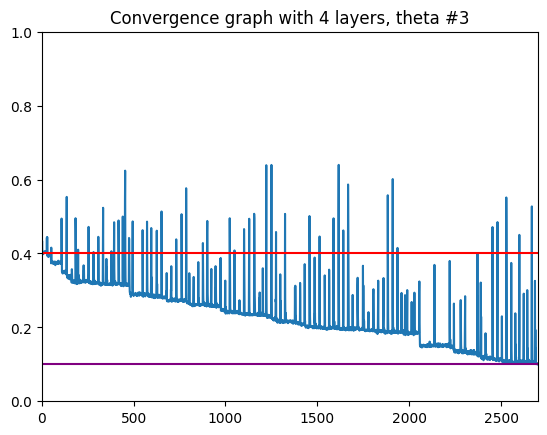

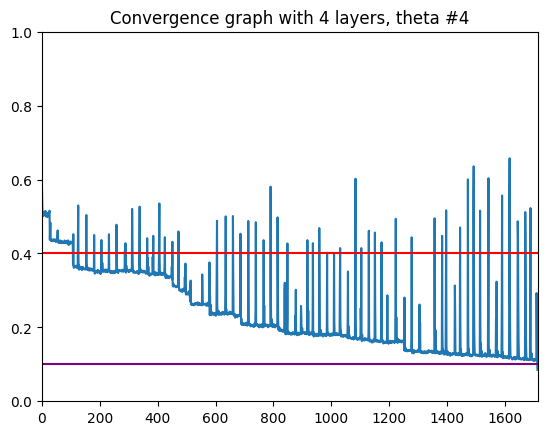

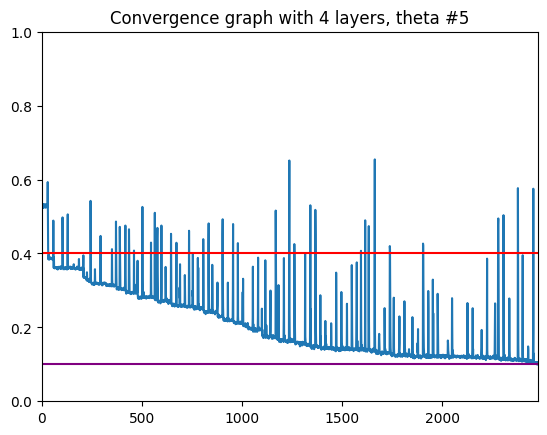

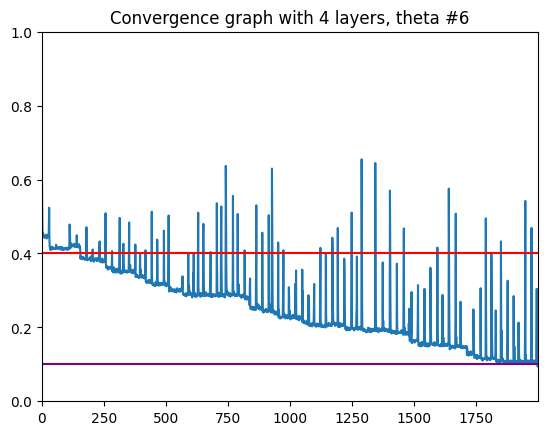

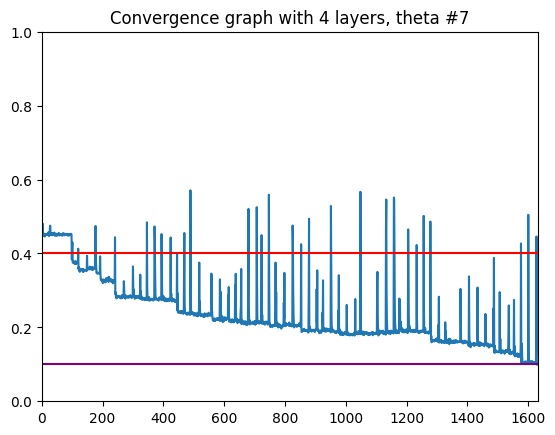

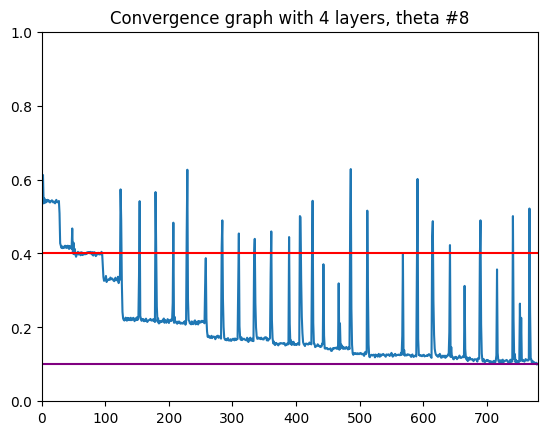

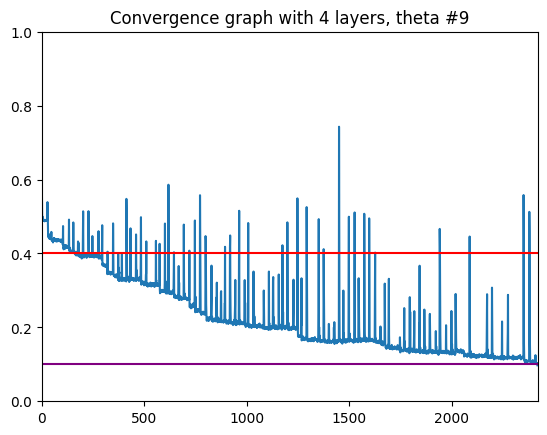

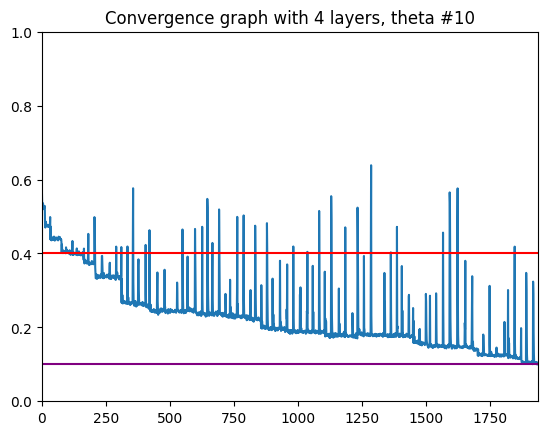

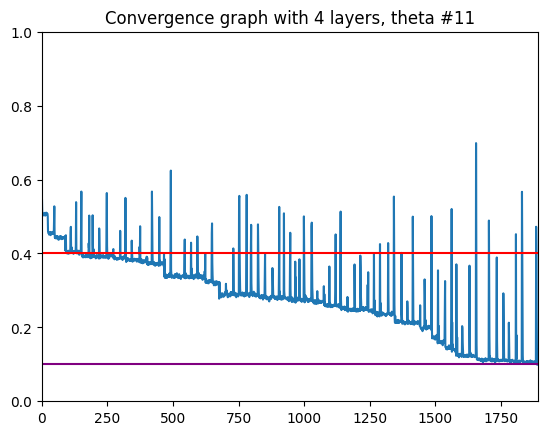

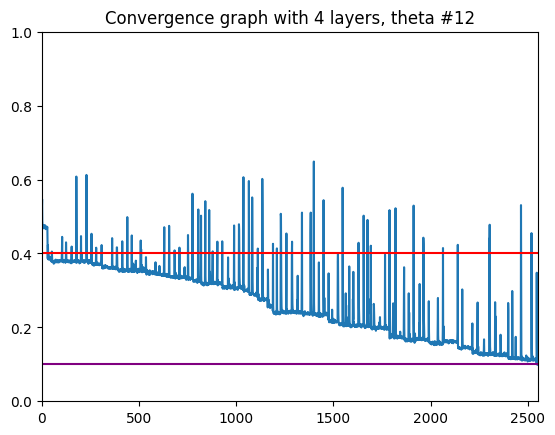

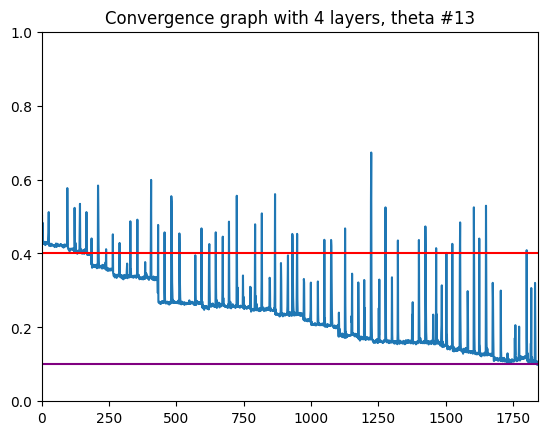

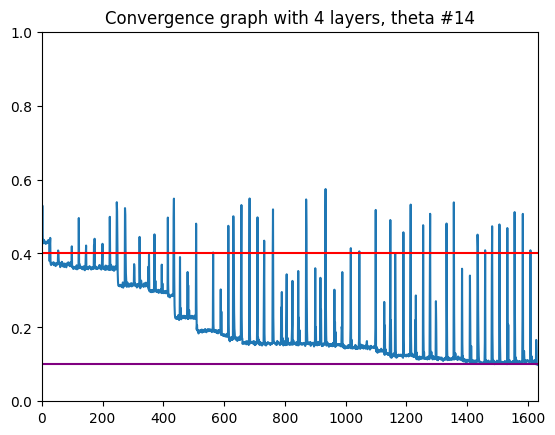

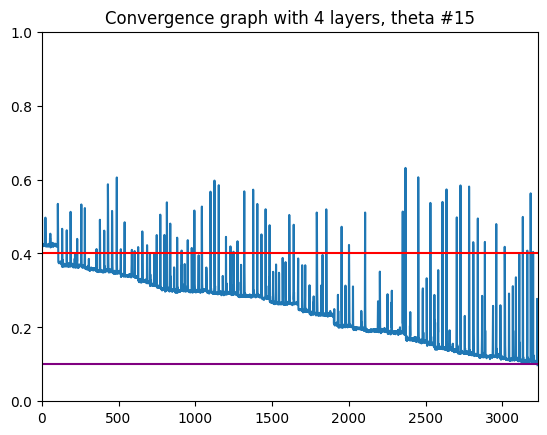

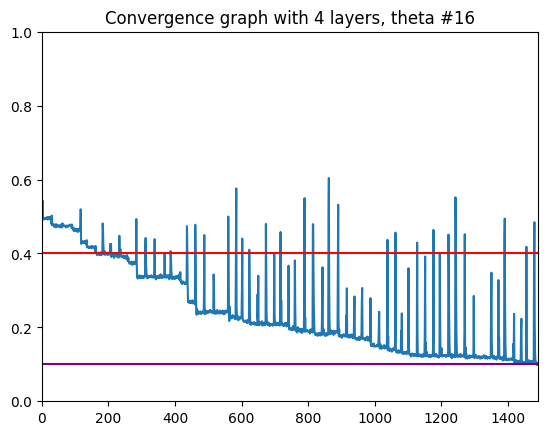

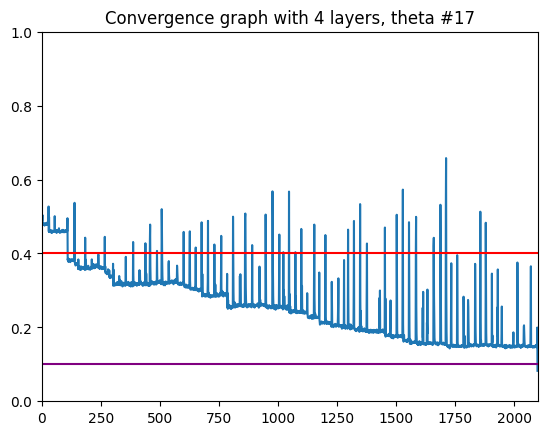

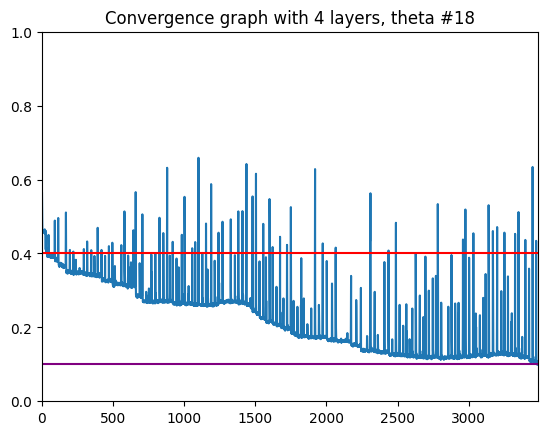

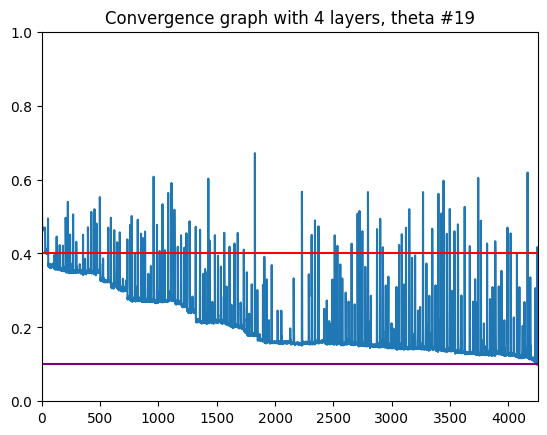

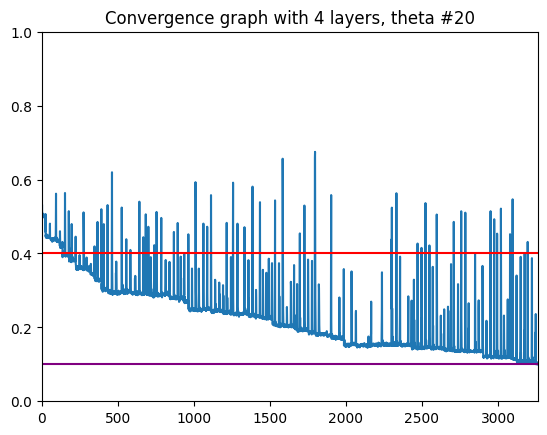

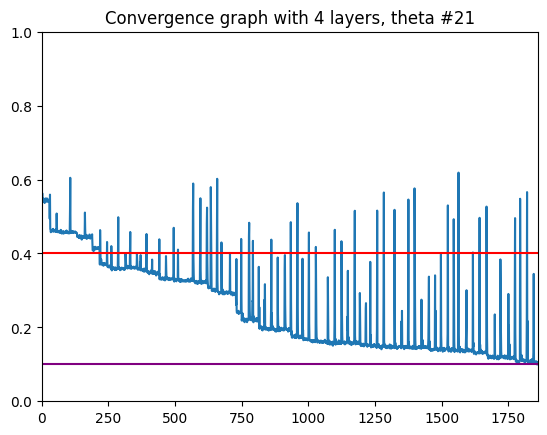

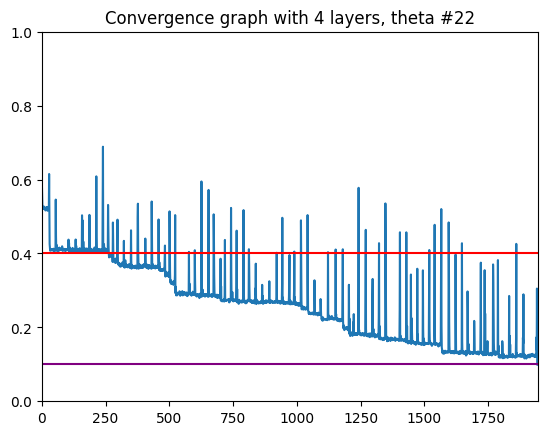

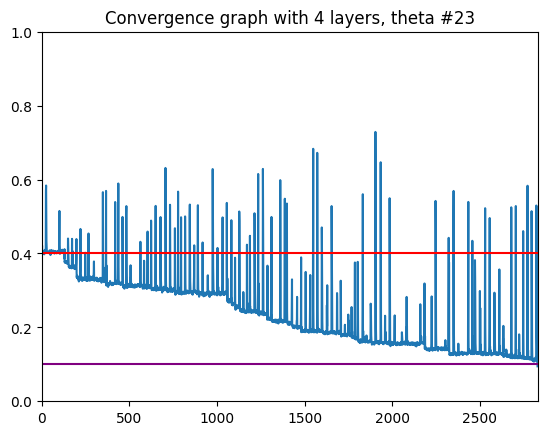

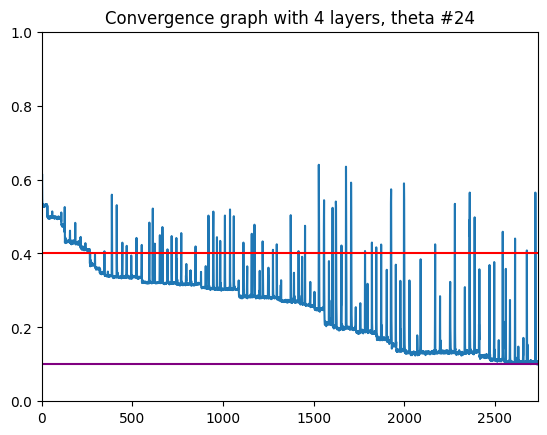

AAAAAAAAAAAAAAAA


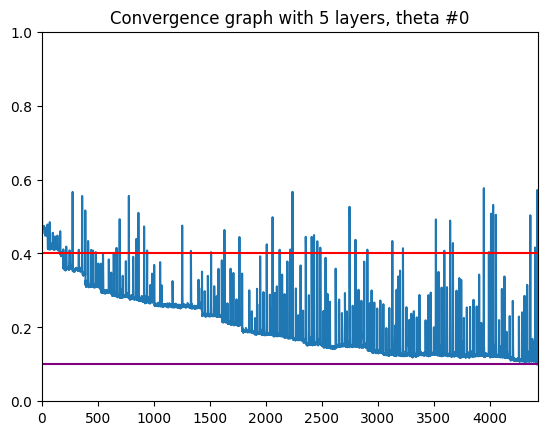

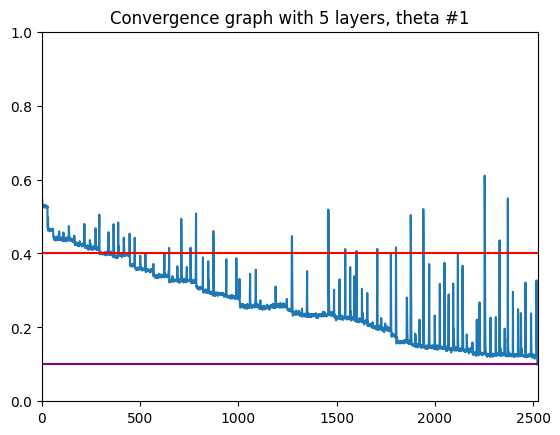

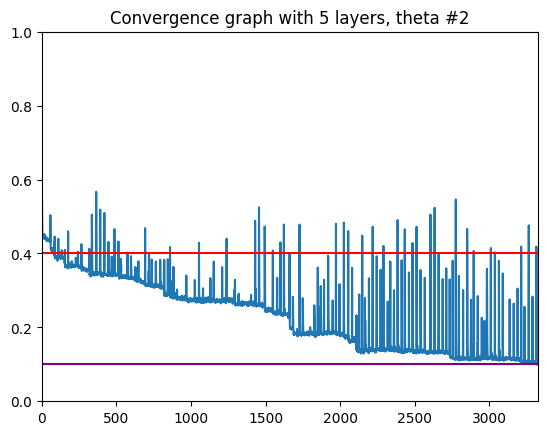

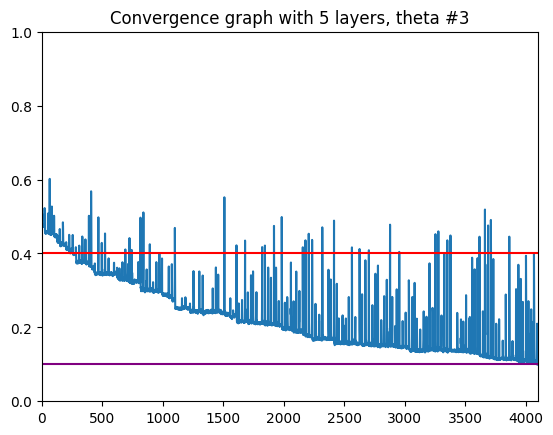

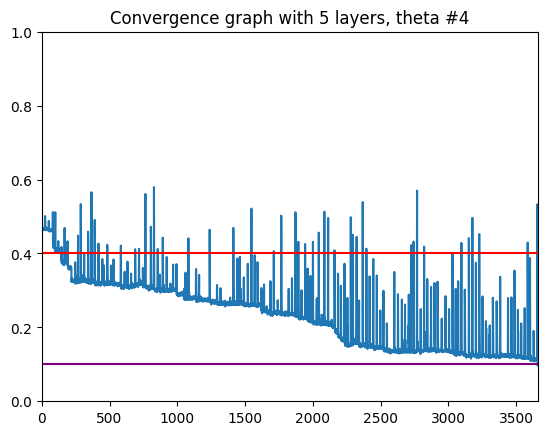

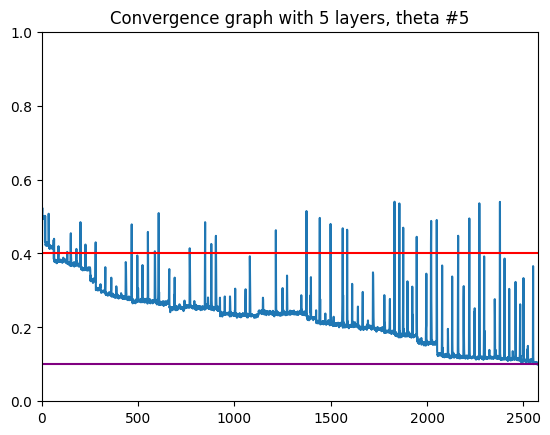

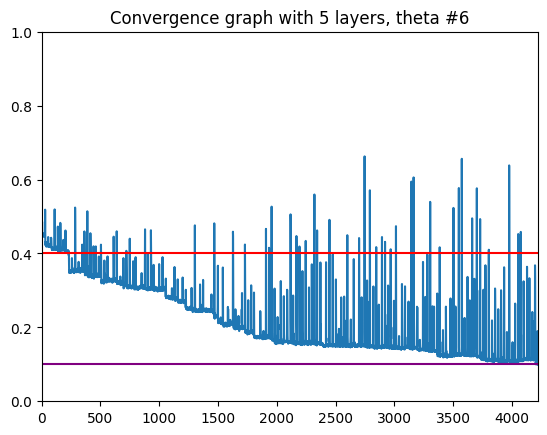

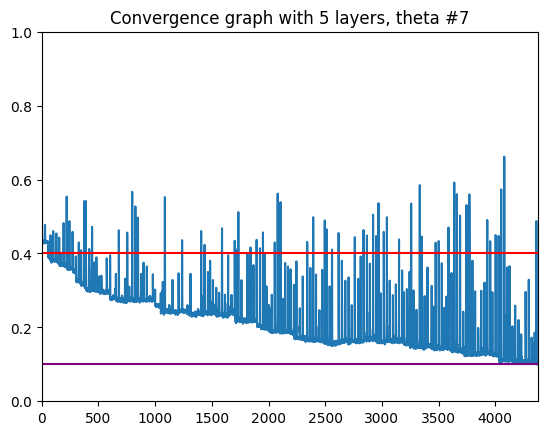

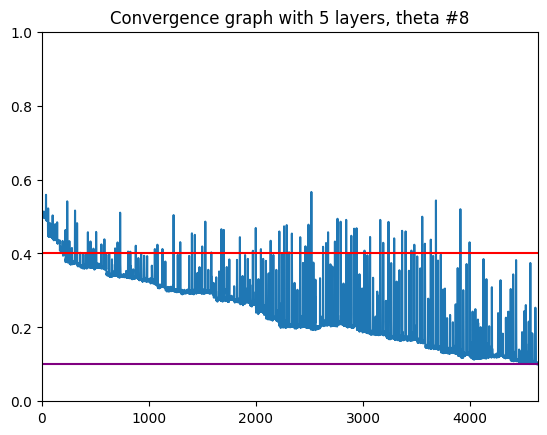

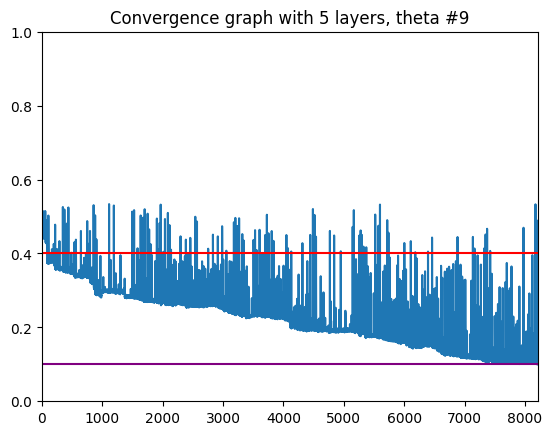

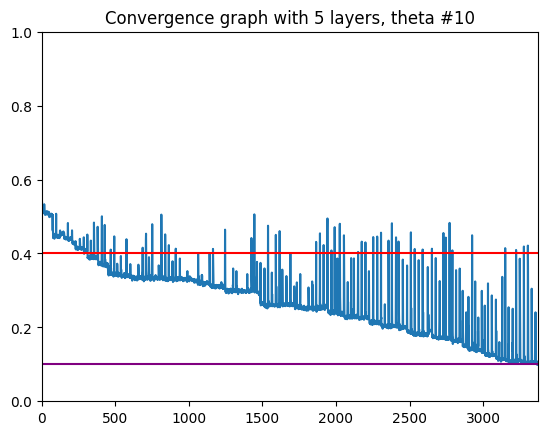

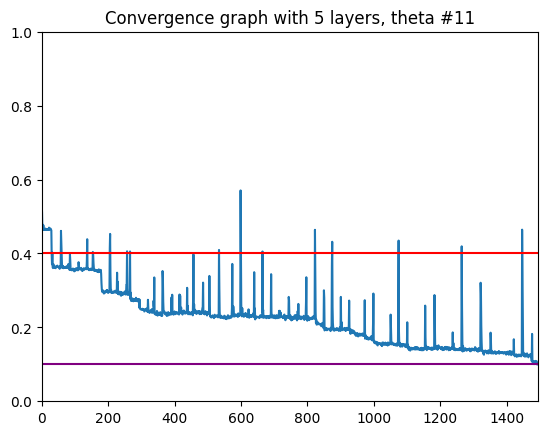

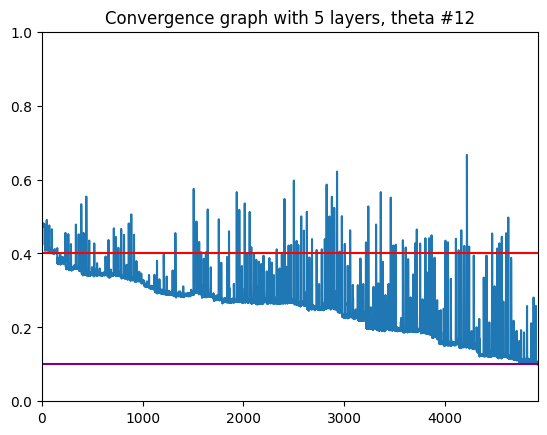

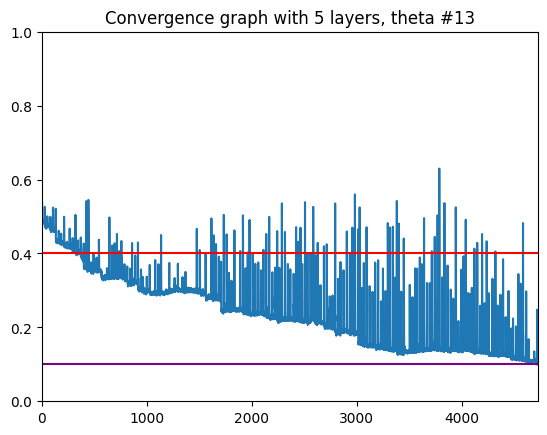

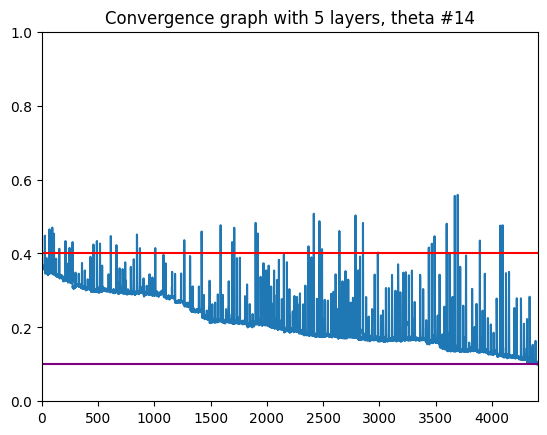

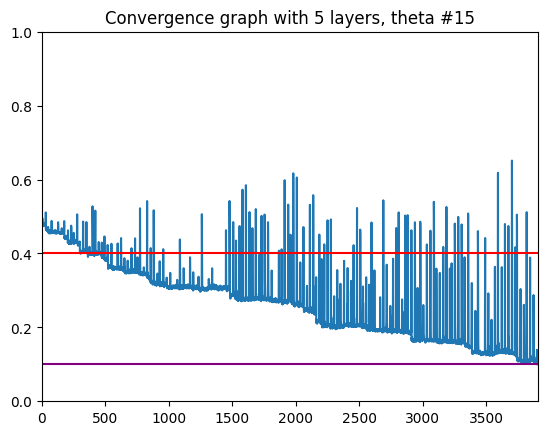

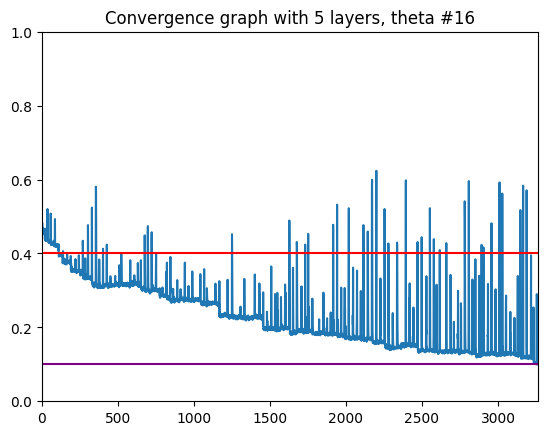

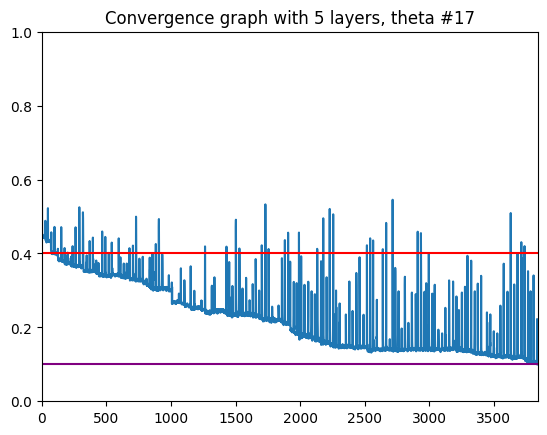

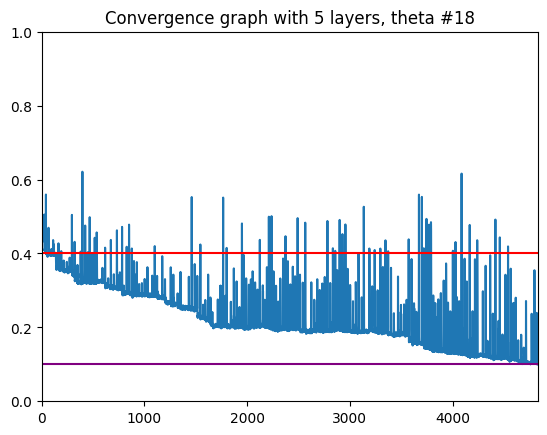

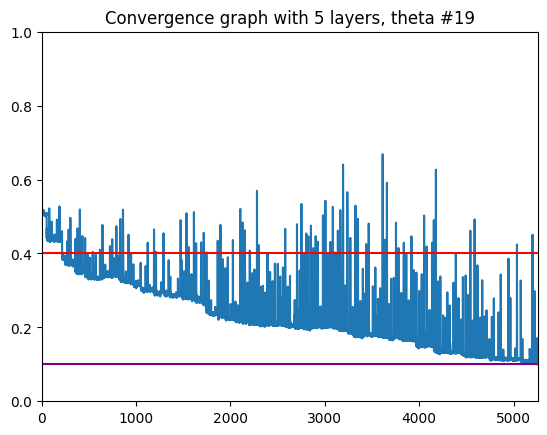

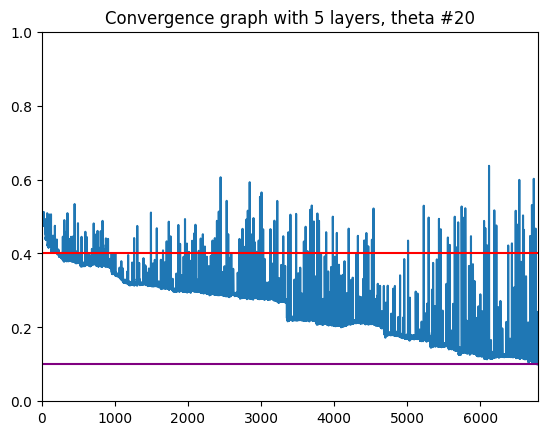

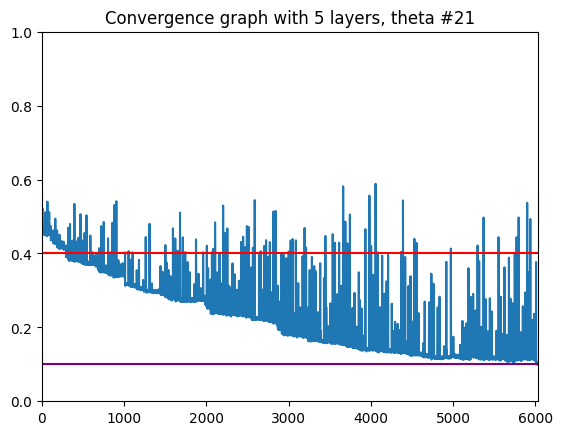

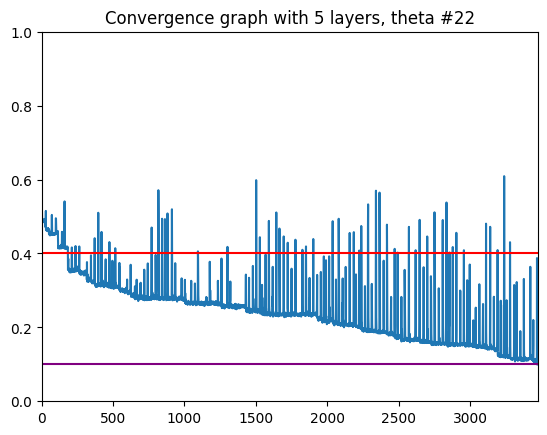

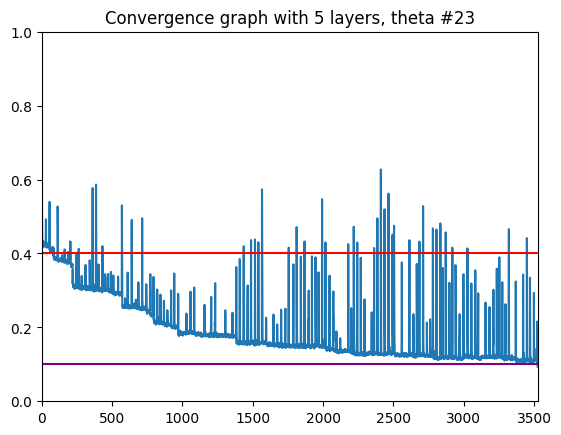

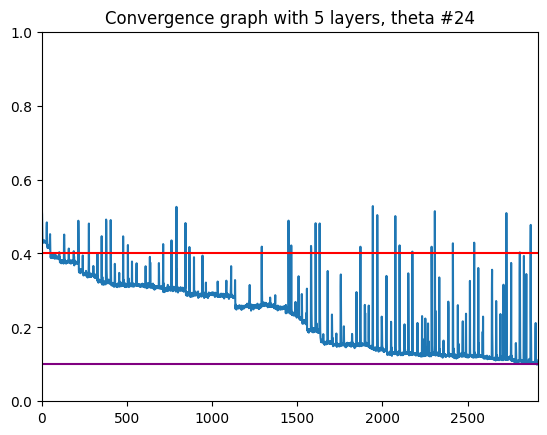

AAAAAAAAAAAAAAAA


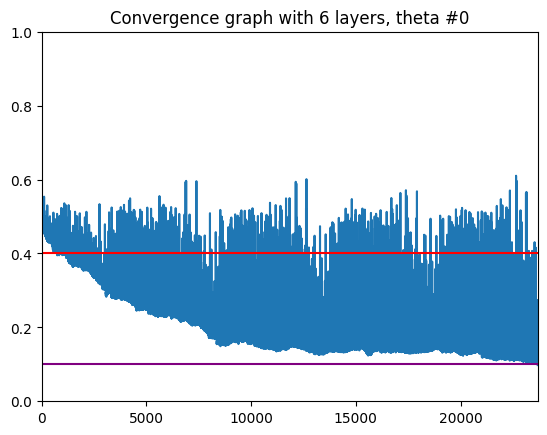

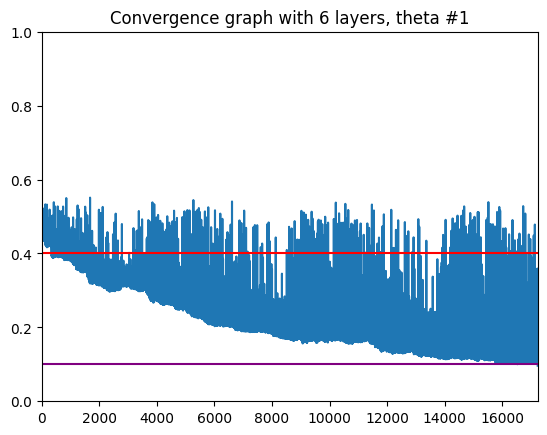

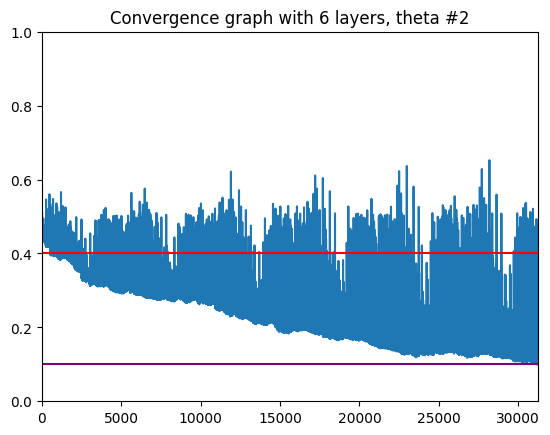

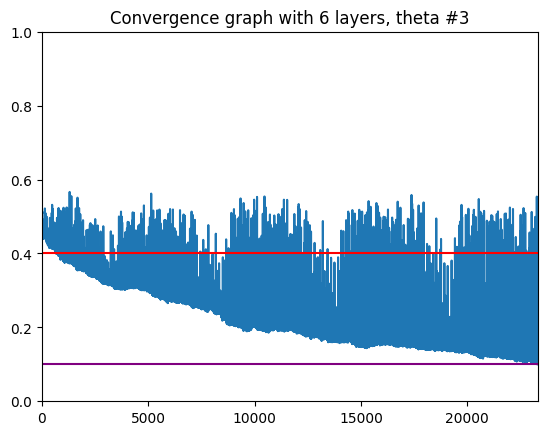

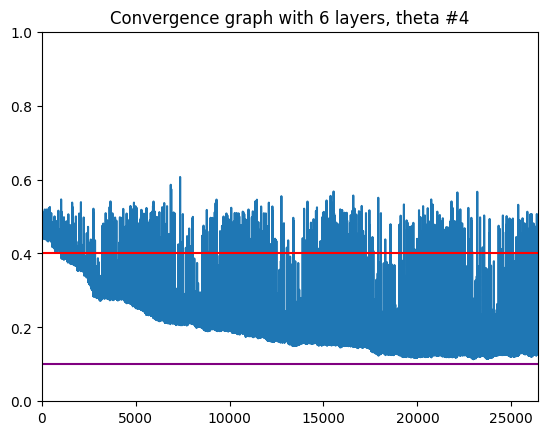

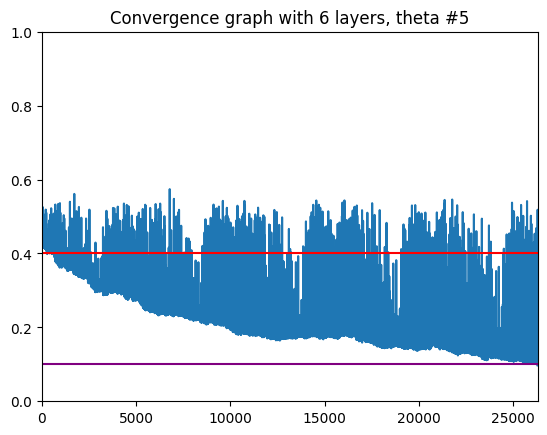

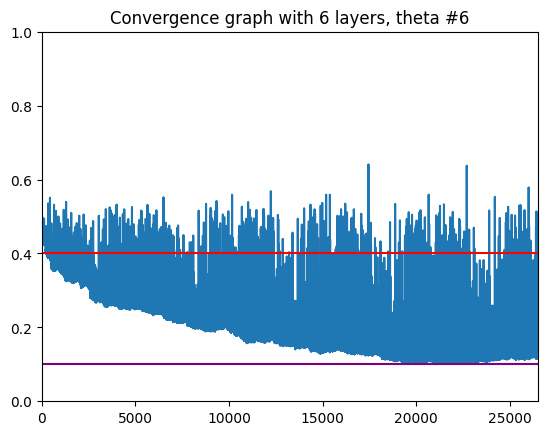

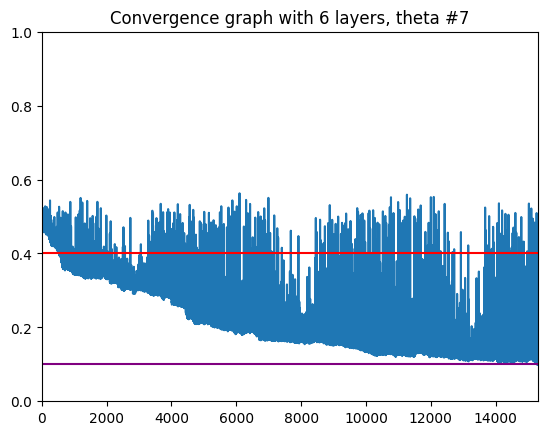

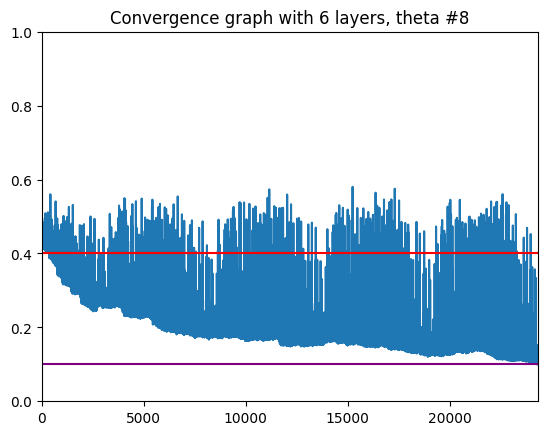

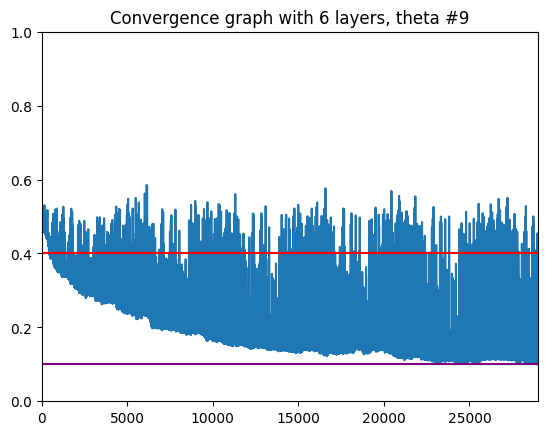

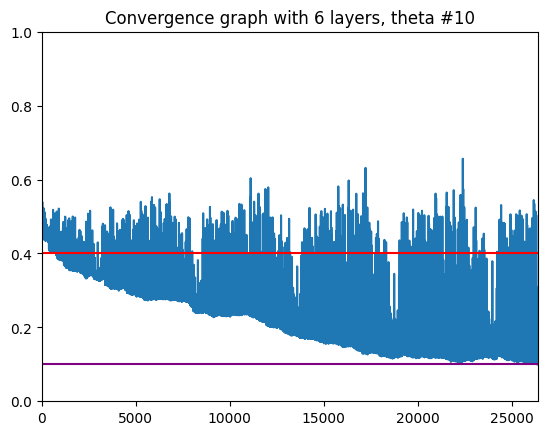

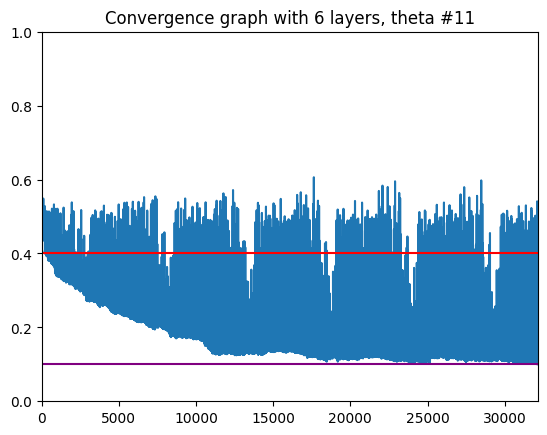

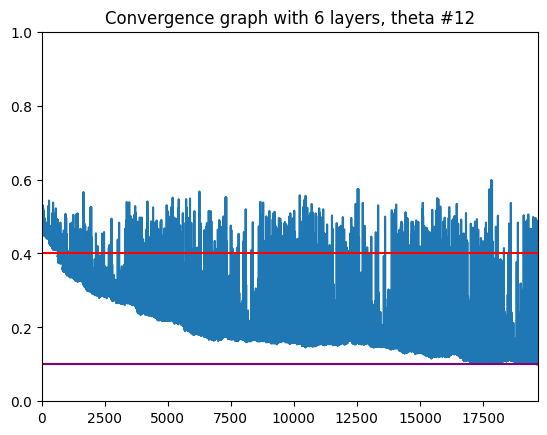

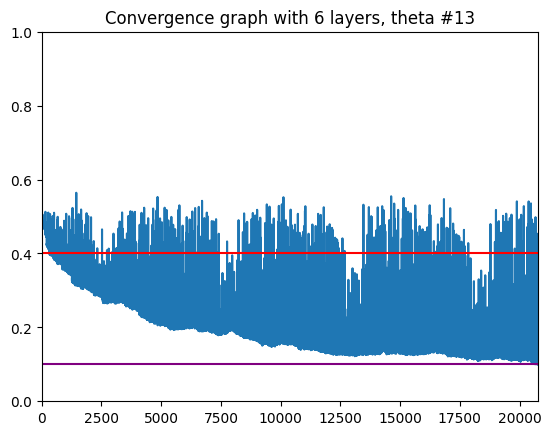

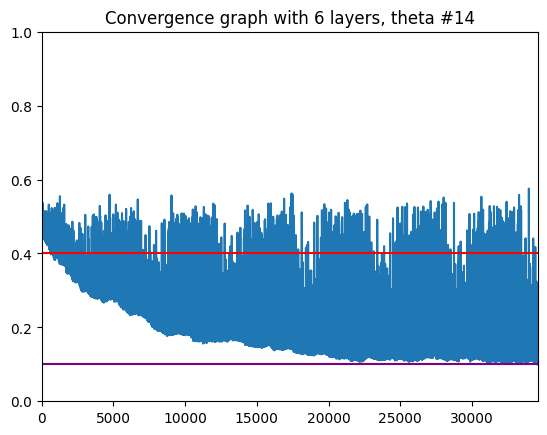

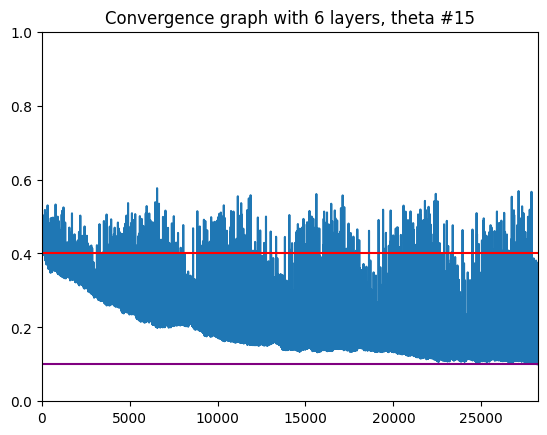

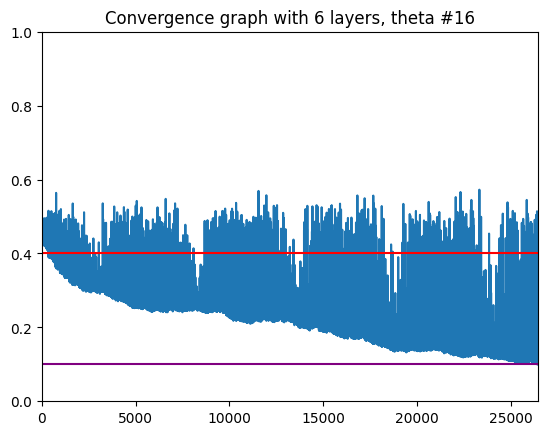

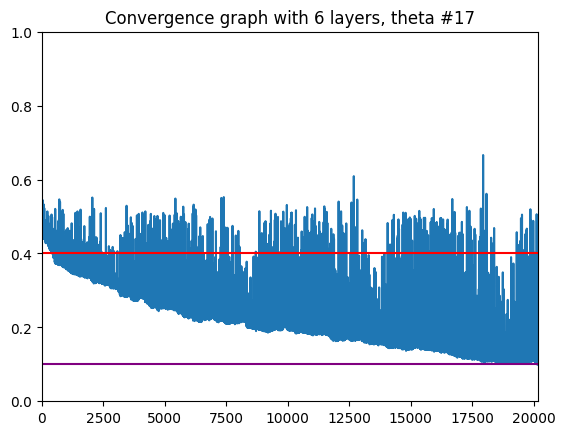

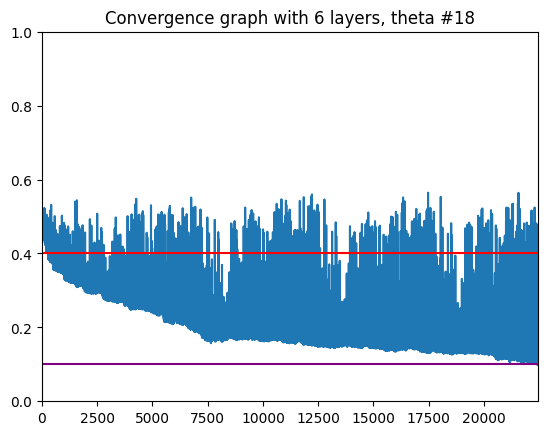

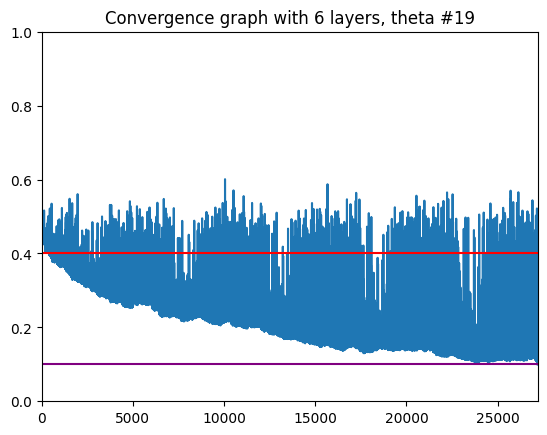

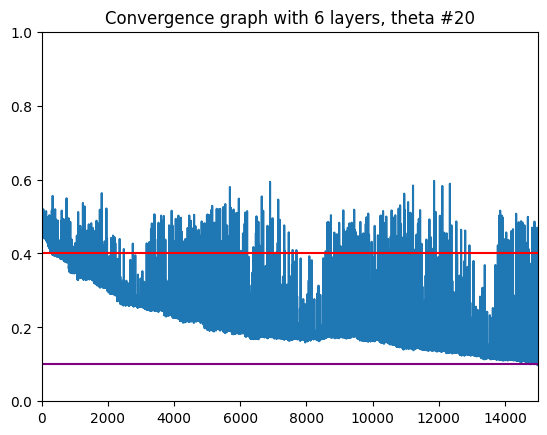

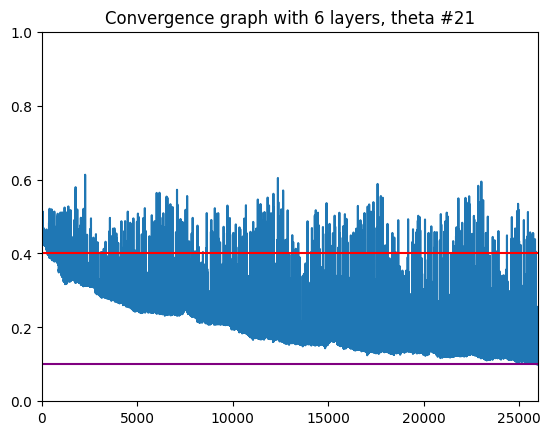

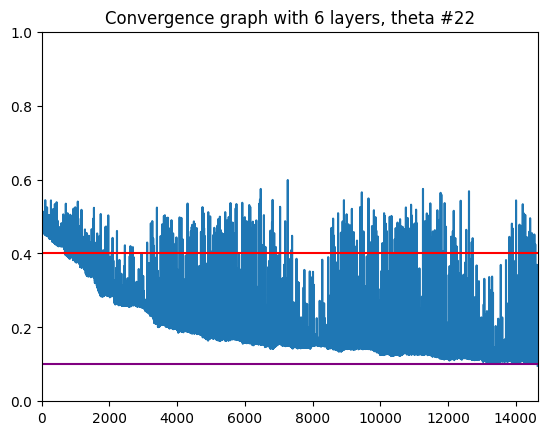

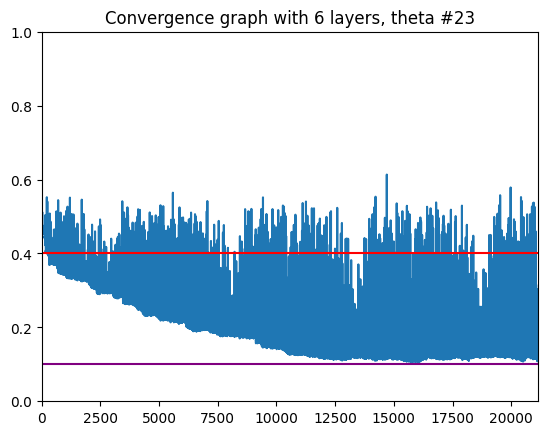

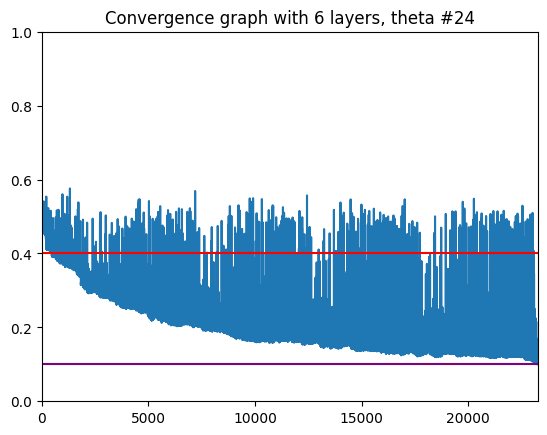

AAAAAAAAAAAAAAAA


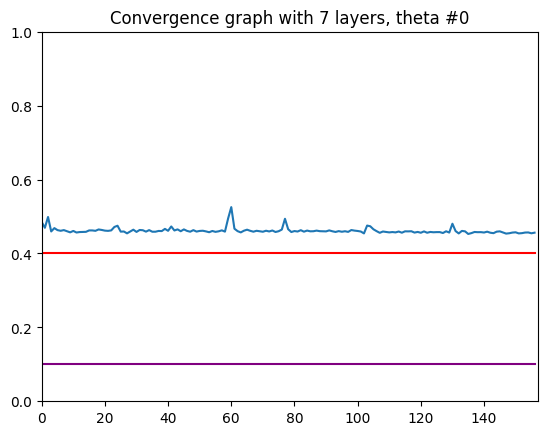

stats for n=4
average nfev: 2297.64
amount of experiments that reached 0.4 is 25/25.
amount of experiments that reached 0.1 is 25/25.
stats for n=5
average nfev: 4190.72
amount of experiments that reached 0.4 is 25/25.
amount of experiments that reached 0.1 is 25/25.
stats for n=6
average nfev: 24049.04
amount of experiments that reached 0.4 is 25/25.
amount of experiments that reached 0.1 is 22/25.
stats for n=7
average nfev: 157.0
amount of experiments that reached 0.4 is 0/1.
amount of experiments that reached 0.1 is 0/1.


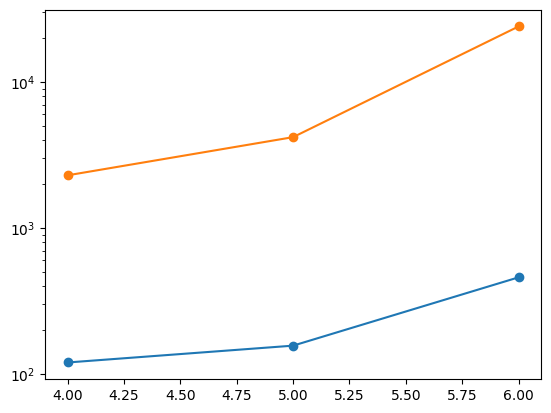

In [106]:
_ = gen_optimizer_stats(random_thetas_results_powell, 'Powell')
_ = gen_optimizer_stats(random_thetas_results_cobyla, 'COBYLA')

### Experiment Set \#1: Barren Plateau Reproduction

In [ ]:
params = get_std_params_7_qubits()
reproduction_results = {}
for n in range(4,11):
    params.n_qubits = params.n_layers = n
    reproduction_results[n], graceful = run_k_random_theta_vqc_exp_set(params)
    if not graceful:
        break

In [ ]:
reproduction_stats = {}
for n in range(4,11):
    params.n_qubits = params.n_layers = n
    print(f'stats for n={n}')
    reproduction_stats[n] = gen_statistics_random_thetas(reproduction_results[n],
                                                        params=params,
                                                        target_vals = [HI_SUCCESS_BOUND],
                                                        stats_folder = os.path.join(VQC_FOLDER, EXP_1_FOLDER),
                                                        stats_filename = f'{n}_layers_{STATS_FILENAME}')

#### Experiment \#1: Figures

In [ ]:
reproduction_dir = os.path.join(os.getcwd(), VQC_FOLDER, 'local cost barren plateaus',EXP_1_FOLDER)
if LOAD_STATS_FROM_FILES:
    reproduction_dict = {n: load_stats(os.path.join(reproduction_dir, f'{n}_layers_{STATS_FILENAME}')) for n in range(4,11)}
else:
    reproduction_dict = reproduction_stats

nfevs_dict = {k: avg(v['nfevs'].values()) for k,v in reproduction_dict.items()}
myplot(nfevs_dict, label='Number of function evals per Number of qubits, COBYLA optimizer, 5 repetitons', logscale=True, xaxis='n', yaxis='nfevs')
plt.show()

### Experiment Set \#2: 3 qubit, 12 layers

In [ ]:
params = get_std_params_3_qubits()
params.optimizer='Powell'
mub_results_3_qubits = {}
random_thetas_3_qubits = {}
mub_state_results, _ = run_k_mub_state_vqc_exp_set(params)
random_thetas_results, _ = run_k_random_theta_vqc_exp_set(params)

In [ ]:
mub_state_stats = gen_statistics_mubs(mub_state_results,
                                      params=params,
                                      target_vals = [HI_SUCCESS_BOUND, LO_SUCCESS_BOUND],
                                      stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, EXP_2_FOLDER,MUBS_FOLDER),
                                      stats_filename = STATS_FILENAME)
random_thetas_stats = gen_statistics_random_thetas(random_thetas_results,
                                                   params=params,
                                                   target_vals = [HI_SUCCESS_BOUND, LO_SUCCESS_BOUND],
                                                   stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, EXP_2_FOLDER,RANDOM_THETAS_FOLDER),
                                                   stats_filename = STATS_FILENAME)

#### Experiment \#2: Figures

In [ ]:
control_group_dir = os.path.join(os.getcwd(), VQC_FOLDER, EXP_2_FOLDER,RANDOM_THETAS_FOLDER)
mub_states_dir = os.path.join(os.getcwd(), VQC_FOLDER, EXP_2_FOLDER,MUBS_FOLDER)
if LOAD_STATS_FROM_FILES:
    d_control = load_stats(os.path.join(control_group_dir, STATS_FILENAME))
    d_mub = load_stats(os.path.join(mub_states_dir, STATS_FILENAME))
else:
    d_control = random_thetas_stats
    d_mub = mub_state_stats

In [ ]:
control_nfevs = list(d_control['nfevs'].values())
control_finvals = list(d_control['fin_vals'].values())
mub_nfevs = list(d_mub['nfevs'].values())
mub_finvals = list(d_mub['fin_vals'].values())
compare_same_qubits_experiments_from_stats(nfev1=control_nfevs, nfev2=mub_nfevs, finval1=control_finvals, finval2=mub_finvals, label1='control', label2='experiment')

### Experiment Set \#3: 7 qubits, 7 layers

In [ ]:
std_exp_7_layers()
half_mub_results_7_qubits = {}
random_thetas_7_qubits = {}
half_mub_state_results, _ = run_k_half_mub_state_3_qubit_vqc_exp_set()
random_thetas_results, _ = run_k_random_theta_vqc_exp_set()

In [ ]:
half_mub_state_stats = gen_statistics_half_mubs_3_qubits(half_mub_state_results,
                                      target_vals = [HI_SUCCESS_BOUND, LO_SUCCESS_BOUND],
                                      stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, EXP_3_FOLDER,HALF_MUBS_FOLDER),
                                      stats_filename = STATS_FILENAME)
random_thetas_stats = gen_statistics_random_thetas(random_thetas_results,
                                                   target_vals = [HI_SUCCESS_BOUND, LO_SUCCESS_BOUND],
                                                   stats_folder = os.path.join(os.getcwd(), VQC_FOLDER, EXP_3_FOLDER,RANDOM_THETAS_FOLDER),
                                                   stats_filename = STATS_FILENAME)

### Experiment \#3: Analysis and Figures

In [ ]:
control_group_dir = os.path.join(os.getcwd(), VQC_FOLDER, EXP_3_FOLDER,RANDOM_THETAS_FOLDER)
half_mub_states_dir = os.path.join(os.getcwd(), VQC_FOLDER, EXP_3_FOLDER,HALF_MUBS_FOLDER)
d_control = load_stats(os.path.join(control_group_dir, STATS_FILENAME))
d_half_mub = load_stats(os.path.join(half_mub_states_dir, STATS_FILENAME))

if LOAD_STATS_FROM_FILES:
    d_control = load_stats(os.path.join(control_group_dir, STATS_FILENAME))
    d_half_mub = load_stats(os.path.join(half_mub_states_dir, STATS_FILENAME))
else:
    d_control = random_thetas_stats
    d_half_mub = half_mub_state_stats

In [ ]:
control_nfevs = list(d_control['nfevs'].values())
control_finvals = list(d_control['fin_vals'].values())
half_mub_nfevs = list(d_half_mub['nfevs'].values())
half_mub_finvals = list(d_half_mub['fin_vals'].values())

#remove outlier
idx = [i for i in range(24) if control_nfevs[i] > 170000][0]
del control_nfevs[idx]
del control_finvals[idx]


compare_same_qubits_experiments_from_stats(nfev1=control_nfevs, nfev2=half_mub_nfevs, finval1=control_finvals, finval2=half_mub_finvals, label1='control', label2='experiment')